# Перенос обучения и сравнение архитектур в Pytorch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mWFPzsXw4RQ86iZGswmNY45WTSjZcF9u#scrollTo=9ic0H8b8qO5z)

## Импорт torch

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [ ]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
        
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')
        # dtype = torch.cuda.FloatTensor
        
    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.11
Using device: cuda
cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers (CPU cores): 2


*Отметим* 
Если у вас нет GPU, то в данном уроке рекомендуем использовать Google Colab c включенным GPU.
Для смены среды выполнения (**runtime**) выбирите **Change runtime type** в соответствующем меню.
<br><u><b><Large>После экспериментов не забудьте вернуть среду на `None` так как время выделяемое для работы GPU ограничено.<b><u>


<img src="https://course.fast.ai/images/colab/04.png" width="350">

Для знакомства с Google Colab можно воспользоваться 
[этим](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb) и 
[этим](https://colab.research.google.com/notebooks/basic_features_overview.ipynb), а также
[этим](hhttps://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82) руководствами.

# Перенос обучения при помощи моделей torchvision

В данном уроке мы рассмотрим вопрос использования т.н. предобученной архитектуры в целевой задаче. Напомним, что термин "предобученная" обозначает архитектуру с изначальными значениями весовых параметров, соотвествующиими модели,  обученной на не целевом наборе данных.

На практике очень редко кто-то пытается обучить всю сверточную сеть с нуля (со случайной инициализацией). В том числе, это связано с тем, что относительно редко имеется набор данных достаточного размера и достаточное время/вычислительные рессурсы для обучения. 

Вместо создания и обучения новой архитектуры обычно используют предварительно обученную сеть (предобученную на очень большом наборе данных, например, `ImageNet`, который содержит 1.2 миллиона изображений с 1000 категориями). Результаты предобученной сети используют либо как инициализацию, либо как фиксированный экстрактор признаков (кодировщик признаков).

Предворительно обученные сети могут быть найдены и загружены из любых репозиториев. Одим из наиболее простых способов работы с предобученными сетями является модуль `models` из библиотеки `torchvision`.


Информаци о доступных моделя в библиотеке `torchvision` может быть найдена в соответствующем разделе официального сайта, например, [тут](https://pytorch.org/vision/0.8/models.html).

В этом уроке мы будем использовать модель `resnet18`. Данная модель представляет собой наименьшую в линейке ResNet моделей, представленной в рамках базовых моделей в `PyTorch`. Информация о данной модели может быть найдена на [странице официального сайта `torchvision`](https://pytorch.org/vision/stable/generated/torchvision.models.resnet18.html), а также [тут](https://pytorch.org/hub/pytorch_vision_resnet/) и в официальной статье [тут](https://arxiv.org/pdf/1512.03385.pdf).
<img src="https://pytorch.org/assets/images/resnet.png"  wide = 150 high = 100> 
* https://arxiv.org/pdf/1512.03385.pdf

Мы загрузим предобученную версию модели (аргумент `pretrained=True`).

>*Отметим*, что также модель можно загрузить в виде модуля для последующего использования в рамках построения новых архитектур. Для этого следует создать экземпляр класса ```torchvision.models.ResNet()``` с описанием его структуры в виде блоков. <br>
Также, в последних версихя `PyTorch` модели могут быть загруженны с т.н. `torch.hub`, например в следующем виде.
>```python
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
>```
> Смотрите больше информации о моделях, доступных в доступных  `torch.hub` [тут](https://pytorch.org/hub/research-models/compact).

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
summary(model,input_size=(3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

После загрузки модели нужно заморозить все параметры для экстрактора признаков. Для этого нам нужно установить `requires_grad == False`, чтобы заморозить параметры, чтобы градиенты не вычислялись в `backward()`.

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

Для последующих операций нам также понадобится знать названия всех слоев в сети.

In [ ]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Напомним, что при неоходимости более получения более развернутой инофрмации о слоях можно также воспользоваться вызовом вида
```python
for name, module_ in model.named_modules():
    print(name, '\t structure =',list(module_.size()))
```

Теперь давайте проведем загрузку набора данных. Для этого урока мы попробуем загрузить данные из интернета. Для этого создадим следующие процедуры, позволяющие загрузить архив и распаковать его в нужную директорию в рамках проекта. 

Отметим, что данный пример вдохновлен [этим](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) уроком.

In [ ]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

  0%|          | 0/47286322 [00:00<?, ?it/s]

Extracting /content/data/hymenoptera_data.zip to /content/data


Содержания созданной дирекктории с файлами можно посмотреть, например, следующим образом

In [ ]:
content = os.listdir(dataset_directory)
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'val']
train :	 ['ants', 'bees']
val :	 ['ants', 'bees']


Как видно, в нашем случае набор данных представляет собой абор изображений двух классов. 
Набор разделен на тренировочную и валидационную подвыборки.
Для загрузки данных с диска будем использовать загрузчик `ImageFolder`.

In [ ]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['ants', 'bees']
Number of training examples: 244
Number of validation examples: 153


Также создадим загрузчик данных.

Отметим, следующее. Так как в данном примере предполагается, что мы будем использовать `GPU` (но не обязательно), то мы создадим две версии аргументов загрузчика. В случае  `GPU` мы будем вызов `DataLoader` c аргументом `torch.Generator(device='cuda')`, в ином случае (`CPU`) мы укажем на число процессов для параллелизации (`min(BATCH_SIZE, num_workers)`). 

In [ ]:
BATCH_SIZE = 4
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'num_workers':min(BATCH_SIZE, num_workers)}

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, **kwarg)

valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)

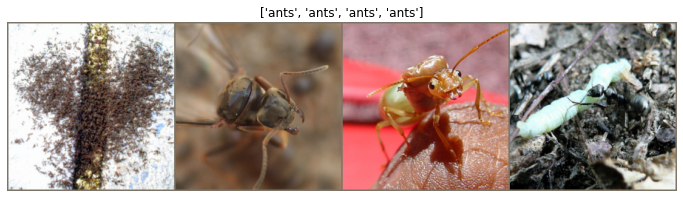

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(valloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[names_classes[x] for x in classes])

После того, как сформирована фиксированная модель можно приступить к разморозке и/или замене части слоев.
Как правило, операриуют только с  головными слоями.

В нашем примере мы замним головной слой (`fc`) на свой, представляющий линейный слой с выходом, равным числу классов. 

Для инициализации нового слоя мы должны будем знать размер его входа. Его мы получим как атрибут `in_features` для соответствующего слоя. Также проинициализируем параметры слоя. Для весовых параметров используем инициализацию Ксавьера, а для смещения инициализацию нулями.

In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

Посмотрим теперь на число тренируем и на общее число параметров.

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 1026
Number of all parameters for the model: 11177538


In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Также выделим тренируемые параметры в отдельный объект.

In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

Запишем параметры обучения.

Отметим, что в данном случае, мы могли бы вместо `trainable_parameters` записать `model.fc.parameters`. Однако, указанный подход более общий.

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)


Также запишим функционал, необходимый для обучения. Данные функции были уже расмортены на предыдущих уроках.

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Проверим, какая точность достигается на тестовых данных в настоящее время 

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.034 | Test Acc: 53.21%


Теперь проведем обучение согласно стандартной процедуре, рассмотренной нами в предыдущих уроках

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion,
                                                accuracy,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   valloader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.435 | Train Acc: 79.51%
	 Val. Loss: 0.228 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.515 | Train Acc: 81.97%
	 Val. Loss: 0.209 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.474 | Train Acc: 79.92%
	 Val. Loss: 0.170 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.289 | Train Acc: 86.89%
	 Val. Loss: 0.188 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.248 | Train Acc: 90.16%
	 Val. Loss: 0.189 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 4s
	Train Loss: 0.475 | Train Acc: 81.97%
	 Val. Loss: 0.273 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 4s
	Train Loss: 0.437 | Train Acc: 82.38%
	 Val. Loss: 0.217 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 4s
	Train Loss: 0.385 | Train Acc: 83.61%
	 Val. Loss: 0.193 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 4s
	Train Loss: 0.448 | Train Acc: 80.74%
	 Val. Loss: 0.187 |  Val. Acc: 95.51%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 4s
	Train Loss: 0.397 | Train Acc: 84.84%
	 Val. Loss: 0.200 |  Val. Acc: 95.51%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 8: Test Loss: 0.162 | Test Acc: 95.51%


Проведенная процедура оказалась достаточно быстрой и дала хорошие результаты.

В учебных целях давайте попробуем разморозить блок кодировщика признаков `layer4` и сравним результаты.

Чтобы узнать состав слоя давайте посмотрим на имена его подмодулей. 
Отметим, что при необходимости, мы также сможем узнать имена параметров слоя используюя `model.layer4.named_parameters()`

In [ ]:
for p in model.layer4.named_modules():
    print(p[0])


0
0.conv1
0.bn1
0.relu
0.conv2
0.bn2
0.downsample
0.downsample.0
0.downsample.1
1
1.conv1
1.bn1
1.relu
1.conv2
1.bn2


Отметим, что каждый слой блока может быть извлечен при помощи метода `get_submodule()`. При необходимости аналогичным образом могут быть извлечены конкретные параметры, для этого вместо `submodule` нужно использовать метод `get_parameters()`.

Перед проведением размораживания слоев давайте перепишем нашу функцию инициализации так, чтобы она могла работать как со сверточными, так и с линейным слоями. 
*Обратите внимание*, что в функции инициализации мы работаем только со слоями `Conv2d` и `Linear`. Если эти обстаятельства не будут указаны, то инциализации будут подвержены и другие элементы архитектуры, например, слой `BatchNorm`.

In [ ]:
def init_weights(m):
    
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
    
    elif isinstance(m, nn.Linear): 
        nn.init.xavier_uniform_(m.weight)
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)

Теперь проведем процедуру разморозки и переинциализации весовых парметров для двух блоков: `model.layer4`, который мы вызвали под псевдонимом `layer_` и `model.fc`. Отметим, также, что если вы переинциализировали изначальную модель, то вам также потребуется заново заменить последний слой на свой. 

In [ ]:
for  m in [model.layer4, model.fc]:
    for param in m.named_parameters():
        print(param[0])
        param[1].requires_grad = True
    m.apply(init_weights);  

0.conv1.weight
0.bn1.weight
0.bn1.bias
0.conv2.weight
0.bn2.weight
0.bn2.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.weight
1.bn1.weight
1.bn1.bias
1.conv2.weight
1.bn2.weight
1.bn2.bias
weight
bias


Проверим, сколько теперь параметров подлежат тренировке.

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 8394754


Также отметим, что в случае, если бы мы хотели переинциализировать только часть слоев блока `layer4`, то следовало бы исползовать следующий код:
```python
layer_ = model.layer4.get_submodule('1.conv2')
for  m in [layer_, model.fc]:
    for param in m.parameters():
        param.requires_grad = True
    m.apply(init_weights);   
```

Теперь мы можем снова проверить точность сети "по умолчанию" для наших данных.

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 9.827 | Test Acc: 55.13%


Проведем переинициализацию параметров обучения.

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)


In [ ]:
trainable_parameters = []
for p in model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)    

Теперь провеним результаты обучения.

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion, 
                                                accuracy,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   valloader, 
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.581 | Train Acc: 75.00%
	 Val. Loss: 0.648 |  Val. Acc: 78.85%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.727 | Train Acc: 71.72%
	 Val. Loss: 0.580 |  Val. Acc: 84.62%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.530 | Train Acc: 80.74%
	 Val. Loss: 0.531 |  Val. Acc: 89.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.536 | Train Acc: 77.46%
	 Val. Loss: 0.610 |  Val. Acc: 83.33%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.529 | Train Acc: 77.46%
	 Val. Loss: 0.355 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.488 | Train Acc: 80.74%
	 Val. Loss: 0.649 |  Val. Acc: 85.26%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 5s
	Train Loss: 0.742 | Train Acc: 77.87%
	 Val. Loss: 0.408 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 5s
	Train Loss: 0.446 | Train Acc: 77.87%
	 Val. Loss: 0.318 |  Val. Acc: 89.74%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 5s
	Train Loss: 0.486 | Train Acc: 82.38%
	 Val. Loss: 0.416 |  Val. Acc: 89.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.428 | Train Acc: 88.11%
	 Val. Loss: 0.594 |  Val. Acc: 87.18%


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 14: Test Loss: 0.297 | Test Acc: 94.23%


Полученные результаты ниже предыдущих. Это связано с рядмо факторов. Во-первых, чем больше параметров подлежат тренировке, тем больший требуется объем входных данных. Во-вторых, вероятно, число эпох обучения достаточно мало. Однако, в целом, полученные результаты лучше, чем  изначально, что позволяет сделать вывод об обучаемости данной модели.

В некоторых случаях, по крайней мере, в учебных целях, вам может понадобится расширить модель, например дополнив ее новой головной частью.  Давайте попробуем сделать такое упражнение. 

Перед началом мы покажем, как получить модель с удалением части ее слоев. Поскольку известна как модель выглядит, мы удалим из нее слой глобального пулинга и последний слой.

In [ ]:
new_model_ = nn.Sequential(*list(model.children())[:-2])
summary(new_model_,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Отметим, что в данном случае мы оставили от модели только т.н. кодировщик признаков. Такая операция может быть весьма удобной в ряде случаев.

Также нам будет полезно получить число признаков, которые мы будем теперь иметь. Эту операцию можно сделать по разному. Например, конкретно для нашей модели, с учетом ее структуры, можно было бы сделать следующим образом.
```python
n_features = list(list(list(new_model_.children())[-1])[-1].children())[-1].num_features
```
В более общем случае мы можем создать тензор ожидаемого входного размера и посмотреть каким он стал на выходе. Например давайте создаим некоторый случайный вектор, имеющий размерность соответствующую размеру батча нашей модели. 
Отметим, что при желании можно просто получить батч тренировочной выборки и проверить точность для него. Для этого моет быть использова следующий код.
```python
x,y = next(iter(trainloader))
x = x.to(device)
```

In [ ]:
x = torch.randn((4,3,224,224), device=device)

out = new_model_(x)
print(out.shape)

n_features = out.shape[1]

torch.Size([4, 512, 7, 7])


Теперь мы попробуем создать новую модель. Модель будет иметь в качестве входных аргуметнов исходную модель `resnet18`, число выделенных кодировщиком (или его частью) признаков  `n_features` и число выходных классов `n_classes`.
В нашей новой модели мы добавим один сверточный слой, который будет снижать число признаков до необходимого `conv_last`. После этого слоя мы создаим новый слой глобального среднего пулинга и новый головной слой.  
Также модель будет включать операции заморозки слоев энкодера и инициализации новых слоев. 

Отметим, что в зависимости от модели число слоев, которые необходимо будет обрезать может варьироваться. В нашем случае мы убираем два верхних слоя - `GAP` и слой классификации (`fc`), поэтому соответствующий параметр `cutlayer=2`.

In [ ]:
class NewResNet(nn.Module):
    def __init__(self, model, n_features=512, n_classes=2, cutlayer =2):
        super().__init__()
        
        self.new_model_ = nn.Sequential(*list(model.children())[:-cutlayer])
        
        for param in self.new_model_.parameters():
            param.requires_grad = False
            
        self.conv_last  = nn.Conv2d(in_channels  = n_features, 
                                    out_channels = 256, 
                                    kernel_size  = 3,
                                    stride       = 1,
                                    padding      = 1,
                                    dilation     = 1)
        
        # self.conv_last.apply(self.init_weights)
        
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc  = nn.Linear(in_features = 256, 
                                out_features = n_classes) 
        
        for m in [self.conv_last, self.fc]:
            m.apply(self.init_weights)
    
    #---------------------------------------------
    def init_weights(self, m):
    
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

        elif isinstance(m, nn.Linear): 
            nn.init.xavier_uniform_(m.weight)

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if m.bias != None:
                m.bias.data.fill_(0)
    
    #---------------------------------------------        
    def forward(self,x):
        x = self.new_model_(x)

        x = torch.relu(self.conv_last(x))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
        

Посмотрим, как выглядит наше модель.

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

new_model = NewResNet(model)
summary(new_model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Проведем инициализацию обучения модели.

In [ ]:
LR = 0.001

new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)


In [ ]:
trainable_parameters = []
for p in new_model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)    

Проверим точность модели на начальном этапе.

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 0: Test Loss: 0.979 | Test Acc: 58.33%


Теперь проведем тренировку модели.

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(new_model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion,
                                                accuracy,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(new_model, 
                                                   valloader, 
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(new_model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

new_model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.442 | Train Acc: 79.51%
	 Val. Loss: 0.192 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.440 | Train Acc: 79.92%
	 Val. Loss: 0.201 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.440 | Train Acc: 79.51%
	 Val. Loss: 0.198 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.336 | Train Acc: 84.02%
	 Val. Loss: 0.177 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.328 | Train Acc: 84.02%
	 Val. Loss: 0.233 |  Val. Acc: 89.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 4s
	Train Loss: 0.305 | Train Acc: 86.48%
	 Val. Loss: 0.179 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 4s
	Train Loss: 0.373 | Train Acc: 82.38%
	 Val. Loss: 0.174 |  Val. Acc: 95.51%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 4s
	Train Loss: 0.292 | Train Acc: 88.52%
	 Val. Loss: 0.181 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 4s
	Train Loss: 0.335 | Train Acc: 83.61%
	 Val. Loss: 0.183 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 4s
	Train Loss: 0.279 | Train Acc: 86.48%
	 Val. Loss: 0.166 |  Val. Acc: 94.87%


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.166 | Test Acc: 94.87%


In [ ]:
new_model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(new_model, valloader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.166 | Test Acc: 94.87%


В данном случае нам удалось улучшить точность для нашего набора данных.

### Упражнения:
1. Попробуйте улучшить `NewResNet` модель.
2. Попробуйте обучить `resnet18` для CIFAR-10. 
3. Для набора данных из этой работы проверьте такие модели,как:
    * `googlenet`,
    * `mobilenet_v2`, 
    * `mobilenet_v3_small`, 
    * `efficientnet_b0`, 
    * `efficientnet_b1`, 
    * `mnasnet0_5`, 
    * `squeezenet1_1`, 
    * `shufflenet_v2_x0_5`.
    не менее 5 моделей.
4. Сравните модели по времени работы и точности.
5. Попытайтесь натренировать полную модель resnet18 c предобученными весами и без них (то есьт все слои надо разморозить)